# Depth Map Prediction from a Single Image using a Multi-Scale Deep Network
Pulkit Adil (200070062),
Akshay Verma (200070005),
Sahil Garg (200070070)

Depth estimation is a crucial task in computer vision, owing to its numerous applications in several fields. Depth estimation using stereo images has been extensively studied, but estimating the depth from a single image still remains an important challenge. This is due to the complexity of mapping 2d images to 3d images, and the lack of ground truth maps available for real-world images. A combination of coarse and fine-scale networks can be used to predict depth maps with high accuracy. The coarse network predicts the depth of the scene globally, while the fine-scale network refines the prediction locally to incorporate finer-scale details.

## Import Libraries

In [ ]:
import os

import pandas as pd

from tqdm.notebook import tqdm

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image

import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Download Dataset

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2'
od.download(dataset_url)

Skipping, found downloaded files in "./nyu-depth-v2" (use force=True to force download)


# Prepare Dataset
The following blocks of code prepare the training and test data for passing through the PyTorch sequential model.  

In [ ]:
train_dir = '/content/nyu-depth-v2/nyu_data'
test_dir = '/content/nyu-depth-v2/nyu_data'

train_csv1 = pd.read_csv('/content/nyu-depth-v2/nyu_data/data/nyu2_train.csv')
test_csv = pd.read_csv('/content/nyu-depth-v2/nyu_data/data/nyu2_test.csv')

train_csv = train_csv1[:9600]
# We use samples from training data folder itself for testing as the data in the test data folder was found to be corrupt
test_csv = train_csv1[9600:9728]

In [ ]:
image_size = (228, 304)
depth_map_size = (55, 74)
batch_size = 128

Torch models require the data to be passed using a Dataloader object. Dataloader object in turn requires that the data be stored in an object of a class inherited from Dataset class.

In [ ]:
class DepthDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform1, transform2):
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.transform1 = transform1
        self.transform2 = transform2
        

    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.csv_file.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        depth_path = os.path.join(self.root_dir, self.csv_file.iloc[index, 1])
        depth_map = Image.open(depth_path).convert('L')

        image = self.transform1(image)
        depth_map = self.transform2(depth_map)

        return image, depth_map

In [ ]:
# Image transforms for resizing and suitably changing images for model training and testing.
transform_img = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor()])

transform_depth = transforms.Compose([transforms.Resize(depth_map_size),
                                      transforms.CenterCrop(depth_map_size),
                                      transforms.ToTensor()])

In [ ]:
# Create Dataset objects for training and testing respectively
train_ds = DepthDataset(train_csv, train_dir, transform_img, transform_depth)
test_ds = DepthDataset(test_csv, test_dir, transform_img, transform_depth)

In [ ]:
# Dataloader objects for 
train_dl = DataLoader(train_ds, batch_size, shuffle = False, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_ds, 640, shuffle = False, num_workers = 2, pin_memory = True)

# Visualize Examples

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_dmaps(depth_maps, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(depth_maps.detach()[:nmax], nrow=8).permute(1, 2, 0), cmap='gray')

def show_batch(dl, nmax=64):
    for images, depth_maps in dl:
        show_images(images, nmax)
        show_dmaps(depth_maps, nmax)
        break

In [ ]:
# show_batch(train_dl)

# Choosing device based on availability (GPU preferred)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

# Global Coarse-Scale Network Model
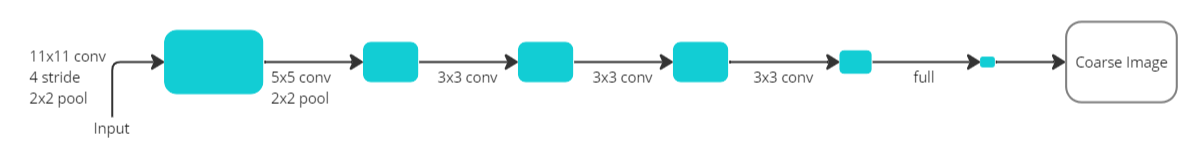

In [ ]:
class CoarseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # in: 3 x 228 x 304

            nn.Conv2d(3, 96, kernel_size = 11, stride = 4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # out: 96 x 27 x 37

            nn.Conv2d(96, 256, kernel_size = 5, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # out: 256 x 13 x 18

            nn.Conv2d(256, 384, kernel_size = 3, padding = 1),
            nn.ReLU(),
            # out: 384 x 13 x 18

            nn.Conv2d(384, 384, kernel_size = 3, padding = 1),
            nn.ReLU(),
            # out: 384 x 13 x 18

            nn.Conv2d(384, 256, kernel_size = 3, stride = 2),
            nn.ReLU(),
            # out: 256 x 6 x 8

            nn.Flatten(1, 3),
            nn.Linear(256*6*8, 4096),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(4096, 4070),
            # nn.Sigmoid()
        )

    def forward(self, img):
        bs = img.size(0)
        coarse = self.network(img)#[:,:4070]
        return torch.reshape(coarse, (bs, 1, 55, 74))

In [ ]:
coarse_model = CoarseNetwork()

# Local Fine-Scale Network
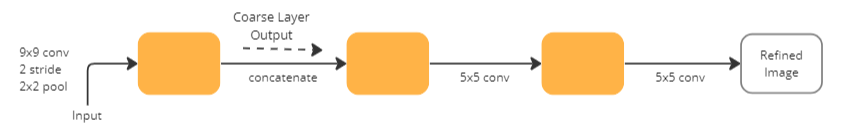

In [ ]:
class FineNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.network1 = nn.Sequential(
            # in: 3 x 304 x 228

            nn.Conv2d(3, 63, kernel_size = 9, stride = 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # out: 63 x 74 x 55  
        )
        self.network2 = nn.Sequential(
            # in: 64 x 74 x 55

            nn.Conv2d(64, 64, kernel_size = 5, padding = 2),
            nn.ReLU(),
            # out: 64 x 74 x55

            nn.Conv2d(64, 1, kernel_size = 5, padding = 2),
            # out: 1 x 74 x 55

            # nn.Sigmoid()
        )
            
    def forward(self, img, coarse):
        fine = self.network1(img)
        fine = torch.cat((fine, coarse), dim = 1)
        return self.network2(fine)

In [ ]:
fine_model = FineNetwork()

# Loss Function


In [ ]:
# Total no. of pixels in the final output images
n = 74 * 55

As described in the research paper we've used the following scale invariant mean squared error (log scale) as the metric for comparing performance in addition to the standard RMSE:

\begin{equation} 
D(y,y^*) = \frac{1}{n} \sum_{i} d_i^2 - \frac{1}{n^2} (\sum_{i} d_i)^2
\end{equation}

where $d_i = \log y_i - \log y^*_i$ $\forall i\in\{1,\cdots,n\}$. 

The following loss function derived from the above mentioned scale invariant error is used for training.

\begin{equation} 
L(y,y^*, \lambda) = \frac{1}{n} \sum_{i} d_i^2 - \frac{\lambda}{n^2} (\sum_{i} d_i)^2
\end{equation}

with $d_i$'s as defined before and the default value of $\lambda$ being 0.5. For the scale invariant error, the loss function can be called with $\lambda=1$.

In [ ]:
def train_loss(pred, target, lmbda=0.5):

    di = pred - torch.log(target+1e-10)
    di2 = torch.square(di)

    error = torch.sum(di2/n, (1, 2, 3)) - lmbda*torch.square(torch.sum(di/n, (1, 2, 3)))
    return error.mean()

# Training The Coarse Network
We've trained the model on only 4 epochs because the training dataset consists of high-resolution images and the size of our neural network is also large. All attempts at training for higher epochs resulted in a "CUDA memory limit exceeded error" and eventually resulting in exhaustion of limits on usage of the GPU available on colab.

In [ ]:
# no. of epochs kept low due to CUDA usage limitations 
epochs = 4

# learning rate                                                                      
lr = 0.0001   

In [ ]:
def train_coarse(epochs, lr, coarse_model, train_dl, opt_func = torch.optim.Adam):
    optimizer = opt_func(coarse_model.parameters(), lr)

    # Load the model into the GPU
    coarse_model = coarse_model.to(device)

    coarse_model.train()

    for epoch in range(epochs):
        coarse_losses = []
        for imgs, dmaps in tqdm(train_dl):

            # Move data into the GPU
            imgs = imgs.to(device)
            dmaps = dmaps.to(device)
            
            preds = coarse_model(imgs)

            loss = train_loss(preds, dmaps)
            coarse_losses.append(loss)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.cuda.empty_cache()

        coarse_losses = torch.Tensor(coarse_losses)
        avg_loss = torch.mean(coarse_losses)
        print('Loss: ' + str(avg_loss))

In [ ]:
train_coarse(epochs, lr, coarse_model, train_dl)

  0%|          | 0/75 [00:00<?, ?it/s]

Loss: tensor(0.4910)


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: tensor(0.2415)


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: tensor(0.2343)


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: tensor(0.2074)


# Training The Fine Network

In [ ]:
def train_fine(epochs, lr, fine_model, train_dl, opt_func = torch.optim.Adam):
    optimizer = opt_func(fine_model.parameters(), lr)

    # Load the model into the GPU
    fine_model = fine_model.to(device)

    fine_model.train()
    coarse_model.eval()

    for epoch in range(epochs):
        fine_losses = []
        for imgs, dmaps in tqdm(train_dl):

            # Move data into the GPU
            imgs = imgs.to(device)
            dmaps = dmaps.to(device)

            # giving the coarse network output as input to the fine network
            coarse_outputs = coarse_model(imgs)
            coarse_outputs = coarse_outputs.to(device)

            preds = fine_model(imgs, coarse_outputs)
            loss = train_loss(preds, dmaps)

            fine_losses.append(loss)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.cuda.empty_cache()

        fine_losses = torch.Tensor(fine_losses)
        avg_loss = torch.mean(fine_losses)
        print('Loss: ' + str(avg_loss))

In [ ]:
train_fine(epochs, lr, fine_model, train_dl)

  0%|          | 0/75 [00:00<?, ?it/s]

Loss: tensor(0.4316)


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: tensor(0.2083)


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: tensor(0.1902)


  0%|          | 0/75 [00:00<?, ?it/s]

Loss: tensor(0.1811)


# Results on test data

In [ ]:
def evaluate(coarse_model, fine_model, test_dl):
    errors = []
    si_errors = []
    rmse_errors = []
    
    # list for storing coarse layer output predictions (batch-wise)
    coarse_outputs_list = []

    # list for storing fine layer output predictions (batch-wise)
    fine_outputs_list = []

    for imgs, dmaps in tqdm(test_dl):
        imgs = imgs.to(device)
        dmaps = dmaps.to(device)

        # coarse layer outputs for a batch
        coarse_outputs = coarse_model(imgs)
        coarse_outputs_list.append(torch.exp(coarse_outputs))

        # fine layer outputs for a batch
        preds = fine_model(imgs, coarse_outputs)
        fine_outputs_list.append(torch.exp(preds))

        # training loss value for a batch
        error = train_loss(preds, dmaps)
        
        # scale-invariant error for a batch
        si_error = train_loss(preds, dmaps, 1)

        # rmse error for a batch 
        rmse_error = torch.sqrt(nn.MSELoss()(preds, dmaps))

        errors.append(error)
        si_errors.append(si_error)
        rmse_errors.append(rmse_error)

    errors = torch.Tensor(errors)
    si_errors = torch.Tensor(si_errors)
    rmse_errors = torch.Tensor(rmse_errors)

    # evaluating average errors
    avg_error = torch.mean(errors)
    avg_si_error = torch.mean(si_errors)
    avg_rmse_error = torch.mean(rmse_errors)

    print('error: {}, scale invariant error: {}, root mean squared error: {}'.format(avg_error, avg_si_error, avg_rmse_error))

    return coarse_outputs_list, fine_outputs_list

In [ ]:
# evaluating the model on test data
batch_coarse_outputs, batch_fine_outputs = evaluate(coarse_model, fine_model, test_dl)

  0%|          | 0/1 [00:00<?, ?it/s]

error: 0.14727848768234253, scale invariant error: 0.09816116094589233, root mean squared error: 1.4661897420883179


In [ ]:
# list for storing coarse network output images
coarse_output_images = []
for i in range(1):
    for j in range(128):
        coarse_output_images.append(batch_coarse_outputs[i].cpu()[j,:,:,:].detach().numpy())

In [ ]:
# list for storing fine layer output images
fine_output_images = []
for i in range(1):
    for j in range(128):
        fine_output_images.append(batch_fine_outputs[i].cpu()[j,:,:,:].detach().numpy())

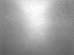

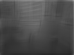

In [ ]:
# displaying sample coarse and fine layer output images
from google.colab.patches import cv2_imshow as imshow
i = 0
imshow(np.transpose(255*coarse_output_images[i]/np.max(coarse_output_images[i]),(1,2,0)))
imshow(np.transpose(155*fine_output_images[i]/np.max(fine_output_images[i]),(1,2,0)))

In [ ]:
# displaying the first 8 images from the list
images = []
for i in range(8):
  for im, depth in test_dl:
      img = np.transpose(np.array(im.detach()[i]), (1,2,0))
      images.append(img*255)
      break

In [ ]:
# creating a horizontal stack of images to be shown
pad = np.ones((images[0].shape[0], 5, 3))*255
stack = np.hstack((images[0], pad, images[1], pad, images[2], pad, images[3], pad, images[4], pad, images[5], pad, images[6], pad, images[7]))

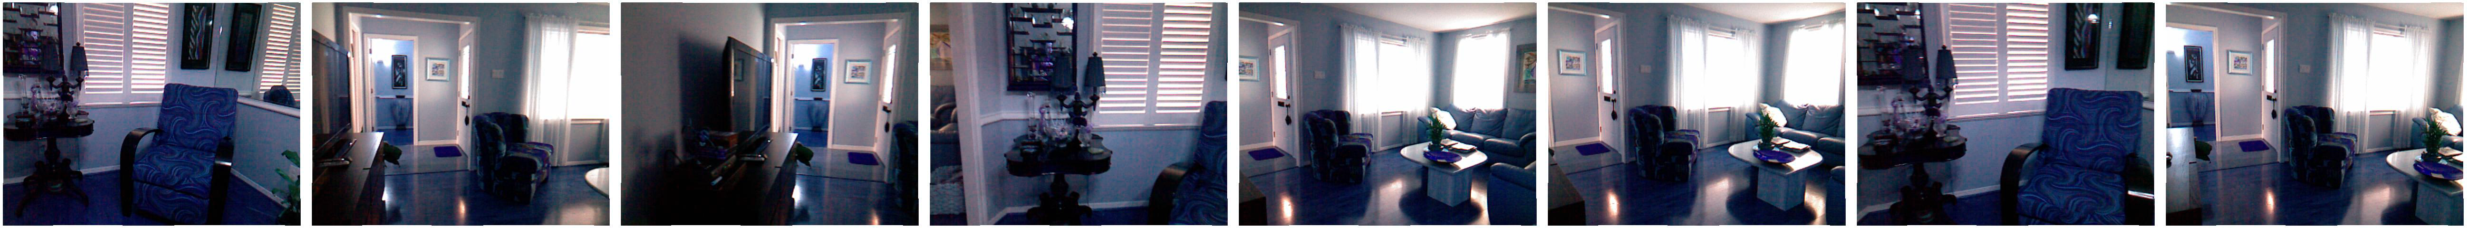

In [ ]:
imshow(stack)

In [ ]:
# displaying the ground truth depth maps of the above images
depths = []
for i in range(8):
  for im, depth in test_dl:
      dp = np.transpose(np.array(depth.detach()[i]), (1,2,0))
      depths.append(dp*255/np.max(dp))
      break

In [ ]:
# creating a horizontal stack of images to be shown
pad = np.ones((depths[0].shape[0], 5, 1))*255
stack = np.hstack((depths[0], pad, depths[1], pad, depths[2], pad, depths[3], pad, depths[4], pad, depths[5], pad, depths[6], pad, depths[7]))

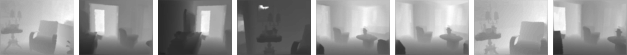

In [ ]:
imshow(stack)

In [ ]:
# displaying the coarse and coarse+fine network prdictions for the above images
coarse = []
fine = []
for i in range(8):
  coarse.append(np.transpose(255*coarse_output_images[i]/np.max(coarse_output_images[i]),(1,2,0)))
  fine.append(np.transpose(255*fine_output_images[i]/np.max(fine_output_images[i]),(1,2,0)))

# creating a horizontal stack of images to be shown
pad = np.ones((coarse_output_images[0].shape[1], 1, 1))
stack_coarse = np.hstack((coarse[0], pad, coarse[1], pad, coarse[2], pad, coarse[3], pad, coarse[4], pad, coarse[5], pad, coarse[6], pad, coarse[7]))
stack_fine = np.hstack((fine[0], pad, fine[1], pad, fine[2], pad, fine[3], pad, fine[4], pad, fine[5], pad, fine[6], pad, fine[7]))

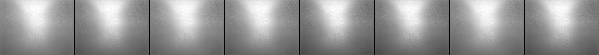

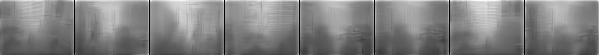

In [ ]:
imshow(stack_coarse)
imshow(stack_fine)